In [13]:
import re
import json

def treat_log(file):
    with open(file) as log:
        log = log.readlines()
        log = [re.sub(' ', '', re.sub('\u200b', '', k)) for k in log]

    # WORKS FOR FIREFOX FORMAT, MAKE WORK FOR ALL FORMATS
    log = [re.sub('search-algorithms.js:[0-9][0-9][0-9]', '', k) for k in log if '##' in k]
    log = [re.sub('blockly_compressed_vertical.js:[0-9][0-9][0-9]', '', k) for k in log]

    # remove SEARCH element, if next element is also SEARCH (most likely same query, different letter)
    for i, e in reversed(list(enumerate(log))):
        if (i != len(log)-1):
            if '##SEARCH' in e and '##SEARCH' in log[i+1]:
                log.pop(i)

    for i, e in list(enumerate(log)):
        # Fixing id mistakes (sometimes id and type are different)
        # we need it to be in reverse for lazy matching
        e = re.sub('}}.*', '}}', e) # Cleans elements that added themselves to the end
        
        if '##CLEAREDSEARCH' in e: # Changes CLEARED SEARCH tag to similar JSON
            e = json.loads('{"cleared": 1}')

        if '##SEARCH' in e:
            e = e[::-1]

            e = re.sub('"?*.xposition"'[::-1], '"motion_xposition"'[::-1], e)
            e = re.sub('"?*.yposition"'[::-1], '"motion_yposition"'[::-1], e)
            e = re.sub('"?*.direction"'[::-1], '"motion_direction"'[::-1], e)
            e = re.sub('"?*.switchcostumeto"'[::-1], '"looks_switchcostumeto"'[::-1], e)
            e = re.sub('"?*.backdropnumbername"'[::-1], '"looks_backdropnumbername"'[::-1], e)
            e = re.sub('"?*.costumenumbername"'[::-1], '"looks_costumenumbername"'[::-1], e)
            e = re.sub('"?*.size"'[::-1], '"looks_size"'[::-1], e)
            e = re.sub('"?*.volume"'[::-1], '"sound_volume"'[::-1], e)
            e = re.sub('"?*.sound_play"'[::-1], '"sound_play"'[::-1], e)
            e = re.sub('"?*.forever"'[::-1], '"control_forever"'[::-1], e)
            e = re.sub('"?*.wait_until"'[::-1], '"control_wait_until"'[::-1], e)
            e = re.sub('"?*.repeat_until"'[::-1], '"control_repeat_until"'[::-1], e)
            e = re.sub('"?*.askandwait"'[::-1], '"sensing_askandwait"'[::-1], e)
            e = re.sub('"?*.answer"'[::-1], '"sensing_answer"'[::-1], e)
            e = re.sub('"?*.loudness"'[::-1], '"sensing_loudness"'[::-1], e)
            e = re.sub('"?*.timer"'[::-1], '"sensing_timer"'[::-1], e)
            e = re.sub('"?*.of"'[::-1], '"sensing_of"'[::-1], e)
            e = re.sub('"?*.current"'[::-1], '"sensing_current"'[::-1], e)

            e = e[::-1]

            e = re.sub('##SEARCH', '', e)
            e = json.loads(e)

        if '##' in e:
            e = re.sub('.*?##', '', e)
            e = re.sub('}[0-9]', '}', e)
            e = json.loads(e)

        log[i] = e
            
    return list(filter(None, log))

In [14]:
def count_logs(log): # takes already treated logs as input
    obj = {'clears': 0, 'unproductive-searchs': 0, 'used': {'total': 0, 'tag': [], 'aut': [], 'sug': [], 'non': []}}

    def where_from(i, block):
        while i >= 0:
            i -= 1
            if 'results' in log[i]:
                if 'tag' in log[i]['results']:
                    if block in log[i]['results']['tag']:
                        return 'tag'
                if 'autocomplete' in log[i]['results']:
                    if block in log[i]['results']['autocomplete']:
                        return 'aut'
                if 'suggestion' in log[i]['results']:
                    if block in log[i]['results']['suggestion']:
                        return 'sug'
                return 'non'
    
    order = 0

    for i, e in list(enumerate(log)):
        if 'cleared' in e:
            obj['clears'] += 1
            if ('tags' in log[i-1]):
                obj['unproductive-searchs'] += 1
        if 'id' in e:
            from_ = where_from(i, e['id'])
            e['time'] = order
            order += 1
            obj['used']['total'] += 1
            if from_ == 'tag':
                obj['used']['tag'].append(e)
            if from_ == 'aut':
                obj['used']['aut'].append(e)
            if from_ == 'sug':
                obj['used']['sug'].append(e)
            if from_ == 'non':
                obj['used']['non'].append(e)

    return obj

In [15]:
def make_data_obj(file, info):
    cleanLog = treat_log(file)
    logCounts = count_logs(cleanLog)
    return {'clean': cleanLog, 'counts': logCounts, 'user': info}
    
foo = []
user1 = {'SUS': [1,2,4,4,5,1,4,4,3,1], 'scratch-level': 'none', 'prog-level': 'expert', 'environment': 'emacs', 'languages': ['C++', 'Python', 'LISP', 'Fortran', 'Java']}
foo.append(make_data_obj('user1.log', user1))
user2 = {'SUS': [1,2,4,2,4,2,5,4,3,2], 'scratch-level': 'beginner', 'prog-level': 'expert', 'environment': 'emacs', 'languages': ['Python']}
foo.append(make_data_obj('user2.log', user2))
user3 = {'SUS': [4,1,5,1,2,3,5,2,4,1], 'scratch-level': 'expert', 'prog-level': 'student', 'environment': 'VSCode', 'languages': ['Java', 'C++', 'Python']}
foo.append(make_data_obj('user3.log', user3))
user4 = {'SUS': [2,1,4,1,4,4,5,3,4,1], 'scratch-level': 'beginner', 'prog-level': 'student', 'environment': 'VSCode', 'languages': ['Java', 'Python', 'JavaScript']}
foo.append(make_data_obj('user4.log', user4))
user5 = {'SUS': [1,2,4,1,5,3,4,1,3,2], 'scratch-level': 'none', 'prog-level': 'student', 'environment': 'VSCode', 'languages': ['Python', 'C++']}
foo.append(make_data_obj('user5.log', user5))
user6 = {'SUS': [1,1,4,4,4,2,4,5,2,1], 'scratch-level': 'none', 'prog-level': 'expert', 'environment': 'emacs', 'languages': ['Python', 'Fortran', 'C++']}
foo.append(make_data_obj('user6.log', user6))
user7 = {'SUS': [2,1,4,1,5,3,5,2,4,1], 'scratch-level': 'none', 'prog-level': 'student', 'environment': 'VSCode', 'languages': ['Python', 'Java', 'JavaScript']}
foo.append(make_data_obj('user7.log', user7))
user8 = {'SUS': [1,1,5,1,4,3,4,1,5,1], 'scratch-level': 'none', 'prog-level': 'student', 'environment': 'VSCode', 'languages': ['C', 'Python', 'C++']}
foo.append(make_data_obj('user8.log', user8))

In [16]:
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd
import numpy as np

def get_blocks(foo, get='all', get_non=False):

    tags = list(it.chain.from_iterable([k['counts']['used']['tag'] for k in foo]))
    auts = list(it.chain.from_iterable([k['counts']['used']['aut'] for k in foo]))
    sugs = list(it.chain.from_iterable([k['counts']['used']['sug'] for k in foo]))
    nons = list(it.chain.from_iterable([k['counts']['used']['non'] for k in foo]))

    if get == 'all':
        return tags, auts, sugs, non

    tag = [k[get] for k in tags]
    aut = [k[get] for k in auts]
    sug = [k[get] for k in sugs]
    non = [k[get] for k in nons]

    if get_non is True:
        return tag, aut, sug, non
    else:
        return tag, aut, sug

def normalize_histogram(array, bins=7):
    colors = []
    for i in range(len(array)):
        colors.append('#FFFFFF00')
    counts, bins, bars = plt.hist(array, bins=bins, color=colors)
    counts = np.array(counts)
    
    counts_normed = counts / (counts.sum(axis=0) + np.spacing(0))
    counts_normed = counts_normed * 100

    x       = [[k.get_x() for k in bars[0]] for bar in bars]
    height  = counts_normed.tolist()

    return x, height


<function matplotlib.pyplot.show(close=None, block=None)>

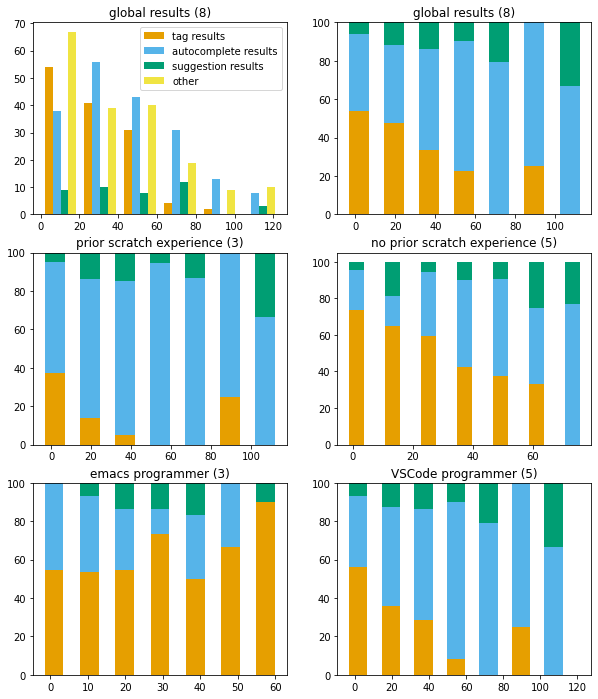

In [17]:
plt.rcParams['figure.figsize'] = (10, 12)

colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442']
names = ['tag results', 'autocomplete results', 'suggestion results', 'other']

fig, ax = plt.subplots(3,2)

#GLOBAL with 'others'
tag, aut, sug, non = get_blocks(foo, get='time', get_non=True)
ax[0][0].hist([tag, aut, sug, non], bins=6, color=colors, label=names)
ax[0][0].set_title('global results ({})'.format(len(foo)))

colors = ['#E69F00', '#56B4E9', '#009E73']
names = ['tag results', 'autocomplete results', 'suggestion results']

#GLOBAL without 'others'
x, height = normalize_histogram([tag, aut, sug])
bottoms = np.zeros(len(height[0]))
for i in range(3):
    ax[0][1].bar(x[i], height[i], bottom=bottoms, color=colors[i], width=10, label=names[i])
    bottoms = bottoms + height[i]
ax[0][1].set_title('global results ({})'.format(len(foo)))

#SCRATCH EXPERIENCE
userList = [k for k in foo if k['user']['scratch-level'] != 'none']
x, height = normalize_histogram(get_blocks(userList, get='time'))
bottoms = np.zeros(len(height[0]))
for i in range(3):
    ax[1][0].bar(x[i], height[i], bottom=bottoms, color=colors[i], width=10, label=names[i])
    bottoms = bottoms + height[i]

ax[1][0].set_title('prior scratch experience ({})'.format(len(userList)))

#NO SCRATCH EXPERIENCE
userList = [k for k in foo if k['user']['scratch-level'] == 'none']
x, height = normalize_histogram(get_blocks(userList, get='time'))
bottoms = np.zeros(len(height[0]))
for i in range(3):
    ax[1][1].bar(x[i], height[i], bottom=bottoms, color=colors[i], width=5, label=names[i])
    bottoms = bottoms + height[i]
ax[1][1].set_title('no prior scratch experience ({})'.format(len(userList)))

#EMACS PROGRAMMERS
userList = [k for k in foo if k['user']['environment'] == 'emacs']
x, height = normalize_histogram(get_blocks(userList, get='time'))
bottoms = np.zeros(len(height[0]))
for i in range(3):
    ax[2][0].bar(x[i], height[i], bottom=bottoms, color=colors[i], width=5, label=names[i])
    bottoms = bottoms + height[i]
ax[2][0].set_title('emacs programmer ({})'.format(len(userList)))

#VSCODE/ST PROGRAMMERS
userList = [k for k in foo if k['user']['environment'] != 'emacs']
x, height = normalize_histogram(get_blocks(userList, get='time'))
bottoms = np.zeros(len(height[0]))
for i in range(3):
    ax[2][1].bar(x[i], height[i], bottom=bottoms, color=colors[i], width=10, label=names[i])
    bottoms = bottoms + height[i]
ax[2][1].set_title('VSCode programmer ({})'.format(len(userList)))

ax[0][0].legend()

plt.show

<BarContainer object of 11 artists>

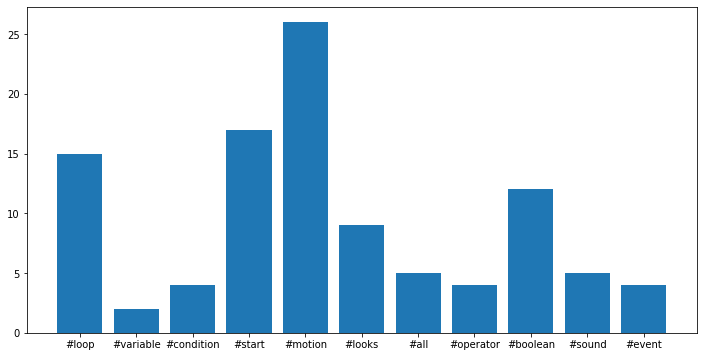

In [18]:
import collections 
plt.rcParams['figure.figsize'] = (12, 6)

all = list(it.chain.from_iterable(list(it.chain.from_iterable([[k['tags'] for k in l['clean'] if 'tags' in k] for l in foo]))))
counter = collections.Counter(all)
plt.bar(counter.keys(), counter.values())

In [19]:
def make_plot(array, label, color, alpha=0.8):
    grades = np.array(array).T

    size = len(grades[0])

    x = []
    for i in range(len(grades)):
        x.append([i]*size)
    
    x = np.array(x)

    noise = np.random.normal(-.05, .05, x.shape)
    x = x + noise
    noise = np.random.normal(-.1, .1, grades.shape)
    grades = grades + noise

    grades = grades.flatten().tolist()
    x = x.flatten().tolist()

    plt.plot(grades, x, 'o', color=color, label=label, ms=8, alpha=alpha)
    plt.xticks([1,2,3,4,5])
    plt.yticks([0,1,2,3,4,5,6,7,8,9])

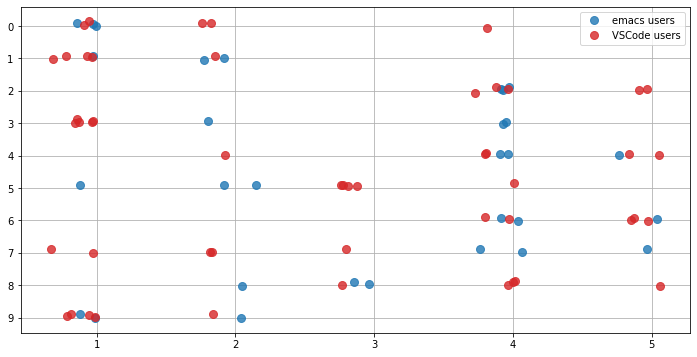

In [20]:
make_plot([k['user']['SUS'] for k in foo if k['user']['environment'] == 'emacs'], 'emacs users', 'C0')
make_plot([k['user']['SUS'] for k in foo if k['user']['environment'] != 'emacs'], 'VSCode users', 'C3')


plt.gca().invert_yaxis()
plt.grid()
plt.legend()

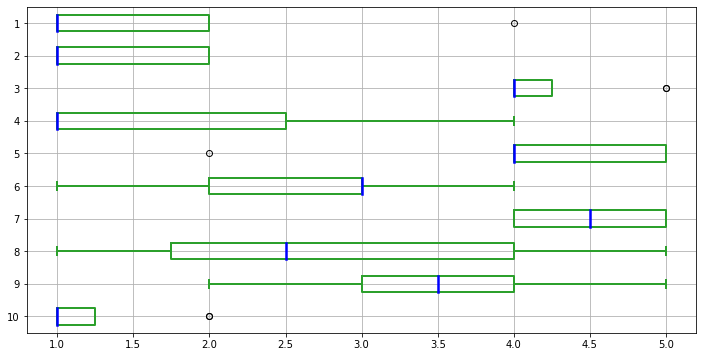

In [21]:
x = np.array([k['user']['SUS'] for k in foo])

boxprops = dict(linewidth=2, color='C2')
medianprops = dict(linewidth=2.5, color='b')
whiskerprops = dict(color='C2', linewidth=2)
flierprops = dict(color='C2', linewidth=2)
capprops = dict(color='C2', linewidth=2)

plt.boxplot(x, vert=False, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, flierprops=flierprops, capprops=capprops)
plt.gca().invert_yaxis()
plt.grid()
plt.show()

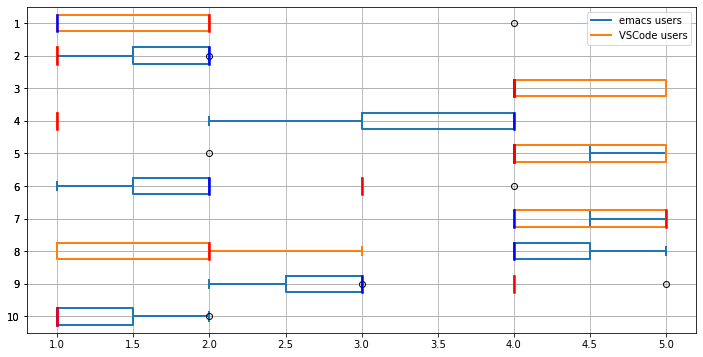

In [22]:
x   = np.array([k['user']['SUS'] for k in foo if k['user']['environment'] == 'emacs'])
x2  = np.array([k['user']['SUS'] for k in foo if k['user']['environment'] != 'emacs'])

boxprops = dict(linewidth=2, color='C0')
medianprops = dict(linewidth=2.5, color='b')
whiskerprops = dict(color='C0', linewidth=2)
flierprops = dict(color='C0', linewidth=2)
capprops = dict(color='C0', linewidth=2)

bp1 = plt.boxplot(x, vert=False, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, flierprops=flierprops, capprops=capprops)

boxprops = dict(linewidth=2, color='C1')
medianprops = dict(linewidth=2.5, color='r')
whiskerprops = dict(color='C1', linewidth=2)
flierprops = dict(color='C1', linewidth=2)
capprops = dict(color='C1', linewidth=2)

bp2 = plt.boxplot(x2, vert=False, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, flierprops=flierprops, capprops=capprops)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['emacs users', 'VSCode users'])
plt.gca().invert_yaxis()
plt.grid()
plt.show()

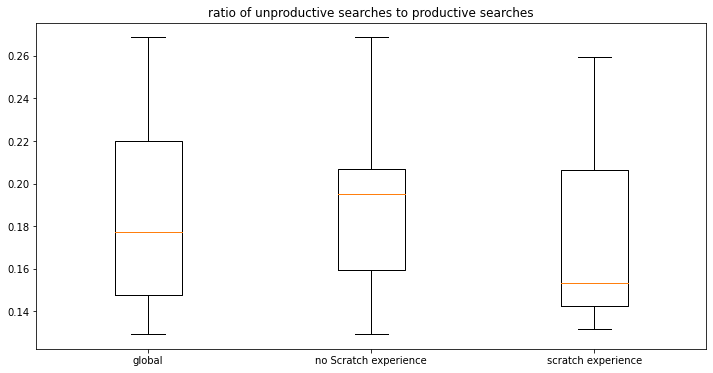

In [23]:
e = [k['counts']['unproductive-searchs']/k['counts']['used']['total'] for k in foo]
u = [k['counts']['unproductive-searchs']/k['counts']['used']['total'] for k in foo if k['user']['scratch-level'] == 'none']
o = [k['counts']['unproductive-searchs']/k['counts']['used']['total'] for k in foo if k['user']['scratch-level'] != 'none']


plt.boxplot([e,u,o], labels=['global', 'no Scratch experience', 'scratch experience'])
plt.title('ratio of unproductive searches to productive searches')
plt.show()

[80.0, 72.5, 70.0, 80.0, 80.0]


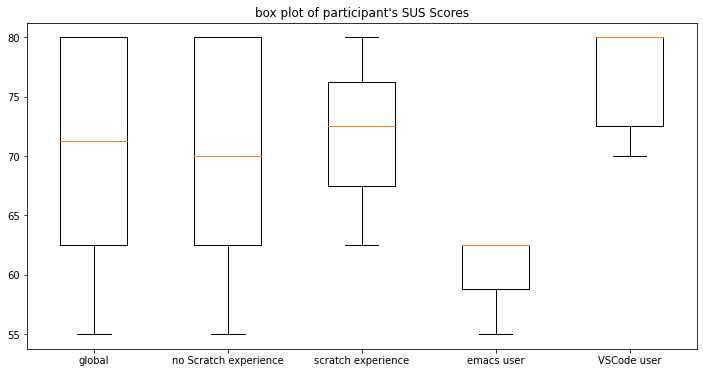

In [24]:
def SUS(scores):
    score = 0
    for i in range(len(scores)):
        if i % 2 == 0:
            score += scores[i] - 1
        else:
            score += 5 - scores[i]

    return score * 2.5

scores = [SUS(k['user']['SUS']) for k in foo]

e = [SUS(k['user']['SUS']) for k in foo]
u = [SUS(k['user']['SUS']) for k in foo if k['user']['scratch-level'] == 'none']
o = [SUS(k['user']['SUS']) for k in foo if k['user']['scratch-level'] != 'none']
a = [SUS(k['user']['SUS']) for k in foo if k['user']['environment'] == 'emacs']
i = [SUS(k['user']['SUS']) for k in foo if k['user']['environment'] != 'emacs']
print(i)

plt.boxplot([e,u,o,a,i], labels=['global', 'no Scratch experience', 'scratch experience', 'emacs user', 'VSCode user'])
plt.title("box plot of participant's SUS Scores")
plt.show()